In [31]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


# EDA 1 

In [91]:
# discover the data 

In [57]:
df = pd.read_csv("../data/nba_logreg.csv")
print(df.shape)
df.head()

(1340, 21)


,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [64]:
df["TARGET_5Yrs"].value_counts()

TARGET_5Yrs
1.0    831
0.0    509
Name: count, dtype: int64

In [65]:
na_counts = df.isna().sum()

print("Nombre de valeurs manquantes par colonne :")
print(na_counts.sort_values(ascending=False))


Nombre de valeurs manquantes par colonne :
3P%            11
GP              0
MIN             0
PTS             0
Name            0
FGM             0
FGA             0
3P Made         0
FG%             0
3PA             0
FTM             0
FTA             0
FT%             0
OREB            0
DREB            0
REB             0
AST             0
STL             0
BLK             0
TOV             0
TARGET_5Yrs     0
dtype: int64


## Distrib

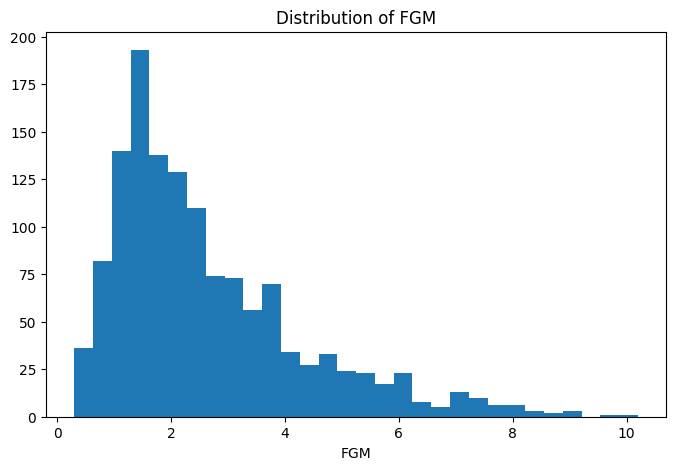

In [78]:
# Columns to plot
# Index(['Name', ' v', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA',
#        '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
#        'TOV', 'TARGET_5Yrs'],
#       dtype='object')
column_name = "FGM"  


plt.figure(figsize=(8, 5))
plt.hist(df[column_name], bins=30)
plt.title(f"Distribution of {column_name}")
plt.xlabel(column_name)
plt.show()

## Correlation matrix 

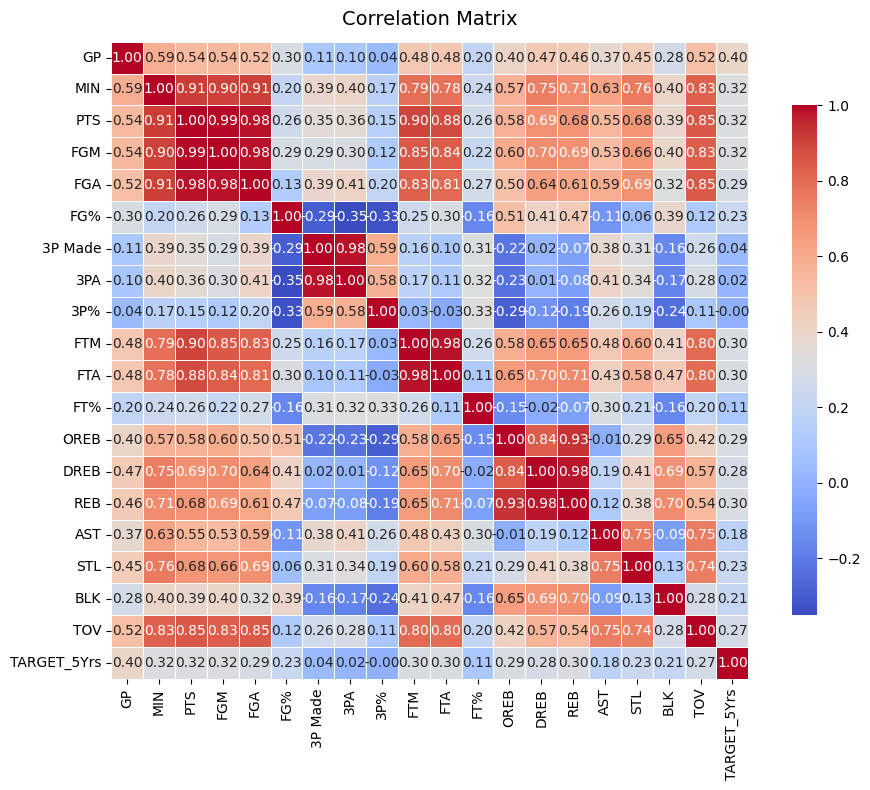

In [67]:
numeric_df = df.select_dtypes(include=["number"])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create the heatmap with Seaborn
sns.heatmap(
    corr_matrix,
    annot=True,        # display correlation values
    fmt=".2f",         # format numbers
    cmap="coolwarm",   # color palette
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

# Cleaning and Features Engineering

In [71]:
# clean existing features and add new ones

In [72]:
df = pd.read_csv("../data/nba_logreg.csv")

## replace Nan

In [73]:
## replace Nan

df["3P%"].fillna(0.0, inplace=True)

C:\Users\natha\AppData\Local\Temp\ipykernel_11932\1207779660.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["3P%"].fillna(0.0, inplace=True)


## Correct percentages

In [74]:
df["3P%"] = df.apply(lambda row : 0.0 if row["3PA"] == 0 else row["3P Made"] / row["3PA"], axis=1)
df["FT%"] = df.apply(lambda row : 0.0 if row["FTA"] == 0 else row["FTM"] / row["FTA"], axis=1)
df["FG%"] = df.apply(lambda row : 0.0 if row["FGA"] == 0 else row["FGM"] / row["FGA"], axis=1)

## add features

In [ ]:
#Assit to turnover and  assist-plus-points-to-turnover ratio

df["ASTperTOV"] = df["AST"] / df["TOV"]
df["ASTPTSperTOV"] = (df["AST"] + df["PTS"]) / df["TOV"]

In [89]:
# get all the MIN-ratio features 

cols = ['GP','PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', "ASTperTOV", "ASTPTSperTOV"]


for col in cols:
    df[f"{col}perMIN"] = df[col] / df["MIN"]


## preprocessing gathering

In [2]:
def pre_process(data_path):

    df = pd.read_csv(data_path)
    df["3P%"].fillna(0.0, inplace=True)
    
    df["3P%"] = df.apply(lambda row : 0.0 if row["3PA"] == 0 else row["3P Made"] / row["3PA"], axis=1)
    df["FT%"] = df.apply(lambda row : 0.0 if row["FTA"] == 0 else row["FTM"] / row["FTA"], axis=1)
    df["FG%"] = df.apply(lambda row : 0.0 if row["FGA"] == 0 else row["FGM"] / row["FGA"], axis=1)

    df["ASTperTOV"] = df["AST"] / df["TOV"]
    df["ASTPTSperTOV"] = (df["AST"] + df["PTS"]) / df["TOV"]

    cols = ['GP','PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', "ASTperTOV", "ASTPTSperTOV"]


    for col in cols:
        df[f"{col}perMIN"] = df[col] / df["MIN"]

    return df
    

# EDA 2 

In [ ]:
# investigate data after pre-processing

In [33]:
df = pre_process2("../data/nba_logreg.csv")
df.head()

C:\Users\natha\AppData\Local\Temp\ipykernel_3184\3294327989.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["3P%"].fillna(0.0, inplace=True)


,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FT%perMIN,OREBperMIN,DREBperMIN,REBperMIN,ASTperMIN,STLperMIN,BLKperMIN,TOVperMIN,ASTperTOVperMIN,ASTPTSperTOVperMIN
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,0.342105,0.5,2.1,0.238095,...,0.025389,0.025547,0.124088,0.149635,0.069343,0.014599,0.014599,0.047445,0.053341,0.261089
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,0.298507,0.7,2.8,0.250000,...,0.028428,0.018587,0.074349,0.089219,0.137546,0.040892,0.018587,0.059480,0.085967,0.253253
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,0.425532,0.4,1.7,0.235294,...,0.045249,0.032680,0.111111,0.143791,0.065359,0.032680,0.019608,0.065359,0.065359,0.405229
3,Malik Sealy,58,11.6,5.7,2.3,5.5,0.418182,0.1,0.5,0.200000,...,0.059682,0.086207,0.077586,0.163793,0.068966,0.051724,0.008621,0.086207,0.068966,0.560345
4,Matt Geiger,48,11.5,4.5,1.6,3.0,0.533333,0.0,0.1,0.000000,...,0.059497,0.086957,0.130435,0.217391,0.026087,0.026087,0.034783,0.069565,0.032609,0.521739


## Correlation with the target

In [5]:
# Compute correlations with TARGET

numeric_df = df.select_dtypes(include=["number"])

target_corr = (
    numeric_df.corr()["TARGET_5Yrs"]              
      .drop("TARGET_5Yrs")                
      .sort_values(ascending=False)  
)


corr_table = target_corr.to_frame(name="Correlation_with_TARGET")
display(corr_table)

,Correlation_with_TARGET
GP,0.396833
MIN,0.317805
FGM,0.317594
PTS,0.315981
REB,0.299406
FTM,0.296841
FTA,0.296089
OREB,0.293307
FGA,0.292660
DREB,0.284677


## PCA

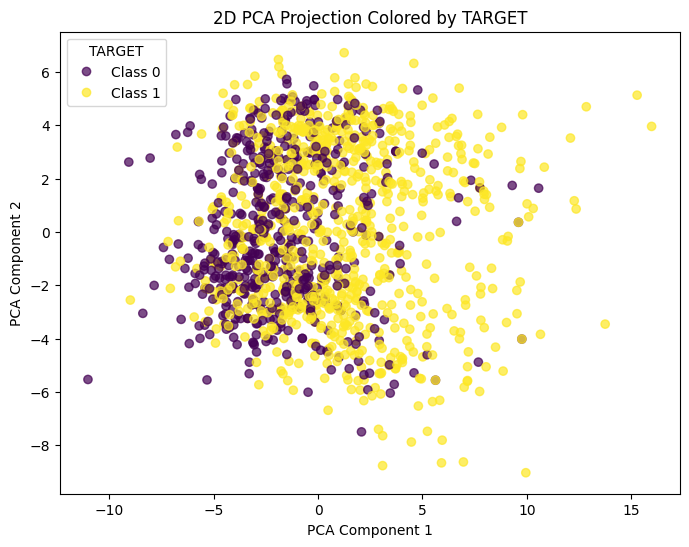

In [36]:
X = df.drop(columns=["TARGET_5Yrs", "Name"], errors="ignore")   # remove non-numeric columns if needed
y = df["TARGET_5Yrs"]

# Keep only numeric columns for PCA
X_numeric = X.select_dtypes(include="number")

# Standardize features (VERY important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Compute PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA in 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y,
    cmap="viridis",        
    alpha=0.7
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Projection Colored by TARGET")

# Add legend
handles, labels = scatter.legend_elements()
plt.legend(handles, ["Class 0", "Class 1"], title="TARGET")

plt.show()

# Dev

In [ ]:
def pre_process2(data_path):

    df = pd.read_csv(data_path)
    df["3P%"].fillna(0.0, inplace=True)
    
    df["3P%"] = df.apply(lambda row : 0.0 if row["3PA"] == 0 else row["3P Made"] / row["3PA"], axis=1)
    df["FT%"] = df.apply(lambda row : 0.0 if row["FTA"] == 0 else row["FTM"] / row["FTA"], axis=1)
    df["FG%"] = df.apply(lambda row : 0.0 if row["FGA"] == 0 else row["FGM"] / row["FGA"], axis=1)

    df["ASTperTOV"] = df["AST"] / df["TOV"]
    df["ASTPTSperTOV"] = (df["AST"] + df["PTS"]) / df["TOV"]

    df["TS%"] = df["PTS"] / (2*(df["FGA"] + 0.44*df["FTA"]))
    df["EFG"] = ((df["FGM"] + 0.5*df["3P Made"])) / df["FGA"]

    scaler = StandardScaler()
    numeric_cols = df.drop(columns=["TARGET_5Yrs"]).select_dtypes(include="number").columns.remove("TARGET_5Yrs")
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    df["EFF"] = df["PTS"] + df["REB"] + df["AST"] + df["STL"] + df["BLK"] - (
        df["TOV"] + (df["FGA"] - df["FGM"]) + (df["FTA"] - df["FTM"])
        )

    cols = ['GP','PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', "ASTperTOV", "ASTPTSperTOV"]


    for col in cols:
        df[f"{col}perMIN"] = df[col] / df["MIN"]

    return df

In [50]:
df = pre_process2("../data/nba_logreg.csv")
df.head()

C:\Users\natha\AppData\Local\Temp\ipykernel_3184\3330312969.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["3P%"].fillna(0.0, inplace=True)


AttributeError: 'Index' object has no attribute 'remove'

In [51]:
# train / test

# Split the DataFrame into two subsets: 80% for training and 20% for testing
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

# Display shapes to verify proportions
print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

print("positive ratio in original set : ", df["TARGET_5Yrs"].sum()/len(df["TARGET_5Yrs"]))
print("positive ratio in training set : ", df_train["TARGET_5Yrs"].sum()/len(df_train["TARGET_5Yrs"]))
print("positive ratio in test set : ", df_test["TARGET_5Yrs"].sum()/len(df_test["TARGET_5Yrs"]))

X_train = df_train.drop(columns=["Name","TARGET_5Yrs"])
X_test = df_test.drop(columns=["Name", "TARGET_5Yrs"])
y_train = df_train["TARGET_5Yrs"]
y_test = df_test["TARGET_5Yrs"]

feature_names = X_train.columns


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set shape: (1072, 46)
Test set shape: (268, 46)
positive ratio in original set :  -1.5907673188658958e-16
positive ratio in training set :  -0.005381565633455862
positive ratio in test set :  0.02152626253382266


In [ ]:
# train / test with only top20 features (Gini importance)

# Split the DataFrame into two subsets: 80% for training and 20% for testing
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

# Display shapes to verify proportions
print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)

print("positive ratio in original set : ", df["TARGET_5Yrs"].sum()/len(df["TARGET_5Yrs"]))
print("positive ratio in training set : ", df_train["TARGET_5Yrs"].sum()/len(df_train["TARGET_5Yrs"]))
print("positive ratio in test set : ", df_test["TARGET_5Yrs"].sum()/len(df_test["TARGET_5Yrs"]))

X_train = df_train.drop(columns=["Name","TARGET_5Yrs"])
X_test = df_test.drop(columns=["Name", "TARGET_5Yrs"])
y_train = df_train["TARGET_5Yrs"]
y_test = df_test["TARGET_5Yrs"]

feature_names = X_train.columns


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = XGBClassifier(


    # Booster parameters
    eta=0.01,
    gamma=0,
    max_depth=3,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    lambda_=1,
    alpha=0,
    n_estimators=500,
    scale_pos_weight = 1,
    tree_method="auto",
    importance_type="gain",

    # Learning task parameters
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42
    
)
model.fit(X_train_scaled, np.asarray(y_train))

y_pred = model.predict(X_test_scaled)

print("=== Test Set Evaluation ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)

plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


c:\Users\natha\OneDrive\Documents\recrutements 2025\MP DATA\NBA-MPDATA-technical_test\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:46:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


ValueError: Must have at least 1 validation dataset for early stopping.

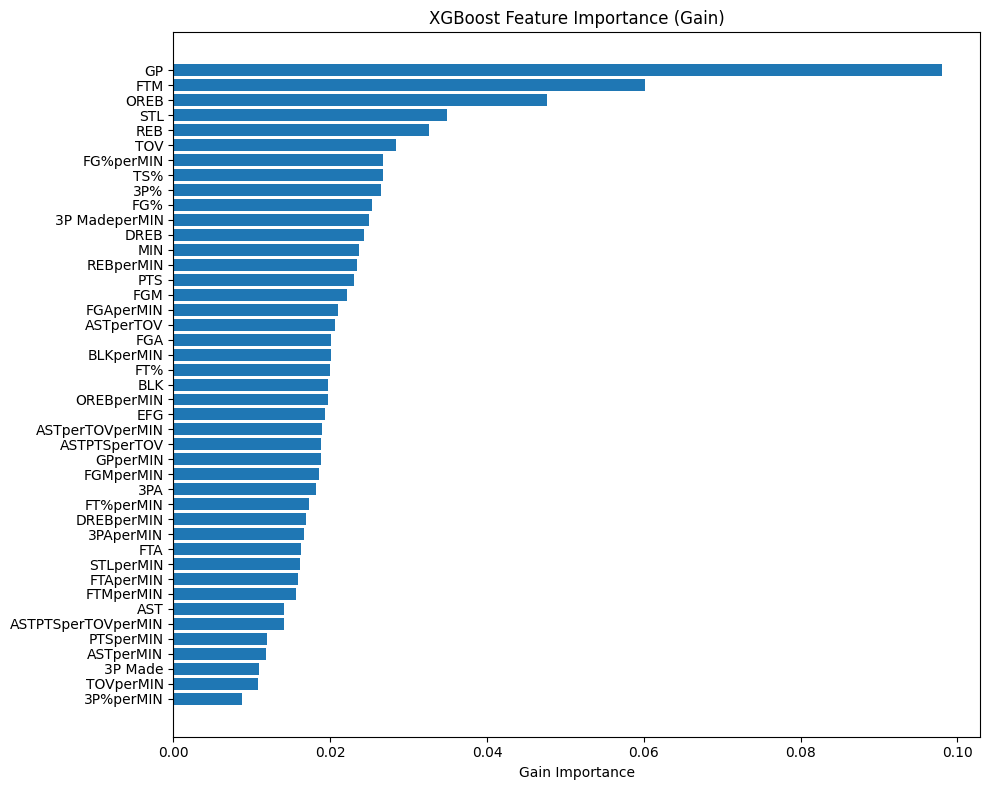

In [12]:
importances = model.feature_importances_importances = model.feature_importances_
# Sort by descending order
indices = np.argsort(importances)[::-1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]
# Plot
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_importances)
plt.gca().invert_yaxis()  
plt.xlabel("Gain Importance")
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()

In [18]:

top20_features = sorted_features[:20]
print(top20_features)

Index(['GP', 'FTM', 'OREB', 'STL', 'REB', 'TOV', 'FG%perMIN', 'TS%', '3P%',
       'FG%', '3P MadeperMIN', 'DREB', 'MIN', 'REBperMIN', 'PTS', 'FGM',
       'FGAperMIN', 'ASTperTOV', 'FGA', 'BLKperMIN'],
      dtype='object')


## Gridsearch

In [ ]:
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.5],
    "n_estimators": [100, 300, 500]
}

# Stratified 5-fold CV
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV over the pipeline
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=cv_splitter,
    n_jobs=-1,
    verbose=0,
    refit=True,
    return_train_score=False,
)

# Fit on training data only (training + validation happen inside CV)
grid.fit(X_train, np.asarray(y_train))

c:\Users\natha\OneDrive\Documents\recrutements 2025\MP DATA\NBA-MPDATA-technical_test\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:25:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(alpha=0, base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eta=0.01,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=0, grow_policy=...
                                     interaction_constraints=None, lambda_=1,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None, max_delta_step=0,
                                     max_depth=3, max_leaves=None,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints=None,
                                     multi_strategy=None, n_estimators=500, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [3],
                         'n_estimators': [100, 300, 500]},
             scoring='f1_weighted')

=== Best CV Result ===
Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best mean CV recall: 0.6772

=== Test Set Evaluation ===
              precision    recall  f1-score   support

         0.0     0.6575    0.4848    0.5581        99
         1.0     0.7385    0.8521    0.7912       169

    accuracy                         0.7164       268
   macro avg     0.6980    0.6685    0.6747       268
weighted avg     0.7086    0.7164    0.7051       268



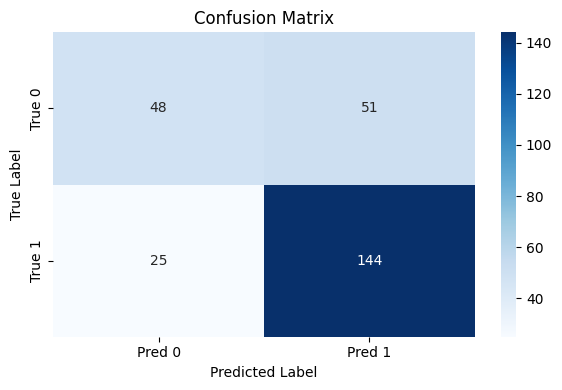

In [40]:
# Report best parameters and CV score
print("=== Best CV Result ===")
print(f"Best params: {grid.best_params_}")
print(f"Best mean CV recall: {grid.best_score_:.4f}")
print()

# Evaluate on the held-out test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("=== Test Set Evaluation ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)

plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Best params: {'eval_metric': 'auc', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}

In [111]:
model = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, np.asarray(y_train))

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [112]:
# Predictions and report
y_pred = model.predict(X_test_scaled)
report = classification_report(y_test, y_pred, digits=2)
print(report)

              precision    recall  f1-score   support

         0.0       0.65      0.52      0.57        99
         1.0       0.75      0.83      0.79       169

    accuracy                           0.72       268
   macro avg       0.70      0.67      0.68       268
weighted avg       0.71      0.72      0.71       268



In [5]:
# -*- coding: utf-8 -*-
"""GridSearchCV with XGBoost on (X_train, y_train) and final test on (X_test, y_test).

This script:
1) Loads the CSV and creates X, y
2) Splits into X_train/X_test (80/20) with stratification
3) Builds a Pipeline: StandardScaler -> XGBClassifier
4) Runs GridSearchCV on X_train with 5-fold Stratified CV
5) Evaluates the best model on X_test and prints a classification report

All comments, variable names, and functions are in English.
"""

from typing import Dict, Any, Tuple


def load_data(path: str) -> Tuple[pd.DataFrame, pd.Series]:
    """Load the CSV and split into features and target."""
    df = pd.read_csv(path)
    df = df.dropna()
    X = df.drop(columns=["Name","TARGET_5Yrs"])
    y = df["TARGET_5Yrs"]
    return X, y


def build_pipeline_xgb(numeric_columns: list[str]) -> Pipeline:
    """Build a preprocessing + classifier pipeline."""
    preprocessor = ColumnTransformer(
        transformers=[("num", StandardScaler(), numeric_columns)],
        remainder="drop",
        n_jobs=None,
    )

    clf = XGBClassifier(
        random_state=42  # keeps other hyperparameters at defaults
    )

    pipe = Pipeline(steps=[("preprocess", preprocessor), ("clf", clf)])
    return pipe

def build_pipeline_logreg(numeric_columns: list[str]) -> Pipeline:
    """Build a preprocessing + classifier pipeline."""
    preprocessor = ColumnTransformer(
        transformers=[("num", StandardScaler(), numeric_columns)],
        remainder="drop",
        n_jobs=None,
    )

    clf = LogisticRegression(
        solver="liblinear",
        max_iter=1000,
        random_state=42,
    )
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("clf", clf)])
    return pipe

def main(classifier_choice) -> None:
    """Run GridSearchCV on X_train and evaluate on X_test."""
    # Load data (adjust the path if needed)
    X, y = load_data("../data/nba_logreg.csv")

    # Train/test split (80/20) with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=40,
        stratify=y,
    )

    # Identify numeric columns (all columns should be numeric in this dataset)
    numeric_columns = X_train.columns.tolist()

    # Build pipeline
    if classifier_choice == "log_reg":
        pipe = build_pipeline_logreg(numeric_columns)

        # Grid of three key hyperparameters (others remain at defaults)
        param_grid: Dict[str, list[Any]] = {
            "clf__C": [0.1, 1.0, 10.0],
            "clf__penalty": ["l1", "l2"],
            "clf__class_weight": [None, "balanced"],
    }
    elif classifier_choice == "xgb":
        pipe = build_pipeline_xgb(numeric_columns)

        # Grid of three key hyperparameters (others remain at defaults)
        param_grid: Dict[str, list[Any]] = {
            "clf__max_depth": [3, 5, 7],
            "clf__learning_rate": [0.01, 0.1, 0.3],
            "clf__n_estimators": [100, 300, 500],
        }

    # Stratified 5-fold CV
    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # GridSearchCV over the pipeline
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv_splitter,
        n_jobs=-1,
        verbose=0,
        refit=True,
        return_train_score=False,
    )

    # Fit on training data only (training + validation happen inside CV)
    grid.fit(X_train, np.asarray(y_train))

    # Report best parameters and CV score
    print("=== Best CV Result ===")
    print(f"Best params: {grid.best_params_}")
    print(f"Best mean CV recall: {grid.best_score_:.4f}")
    print()

    # Evaluate on the held-out test set
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    print("=== Test Set Evaluation ===")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion matrix (test):")
    print(confusion_matrix(y_test, y_pred))



In [ ]:
main(classifier_choice="xgb")

In [28]:
main(classifier_choice="log_reg")

=== Best CV Result ===
Best params: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2'}
Best mean CV recall: 0.7206

=== Test Set Evaluation ===
              precision    recall  f1-score   support

         0.0     0.6000    0.4752    0.5304       101
         1.0     0.7151    0.8061    0.7578       165

    accuracy                         0.6805       266
   macro avg     0.6575    0.6407    0.6441       266
weighted avg     0.6714    0.6805    0.6715       266

Confusion matrix (test):
[[ 48  53]
 [ 32 133]]


## rest 

# rest 